In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import warnings; warnings.filterwarnings("ignore")

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        return self.model(x)

In [ ]:
# Loss function
mseloss = nn.MSELoss(reduction='mean')

# Solution function u as Neural Networks
u_NN = MLP().to(device)

In [ ]:
# Boundary Conditions

# points at boundary
x_bc = np.array([0, 2*np.pi]).reshape(-1, 1)
u_bc = np.array([0, 0]).reshape(-1, 1)

x_bc = torch.tensor(x_bc, dtype=torch.float).to(device)
u_bc = torch.tensor(u_bc, dtype=torch.float).to(device)
u_bc_pred = u_NN(x_bc)

loss_bc = mseloss(u_bc, u_bc_pred)

In [ ]:
# Differential Equations

# collocation points
# x = np.linspace(0, 2*np.pi, 32).reshape(-1, 1)
# x = torch.tensor(x, dtype=torch.float, requires_grad=True).to(device)

x = torch.FloatTensor(32, 1).uniform_(0, 2*np.pi)
x.requires_grad = True
x = x.to(device)

u = u_NN(x)

u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]

def f(x):
    return torch.cos(x)

loss_de = mseloss(u_x, f(x))

<matplotlib.legend.Legend>

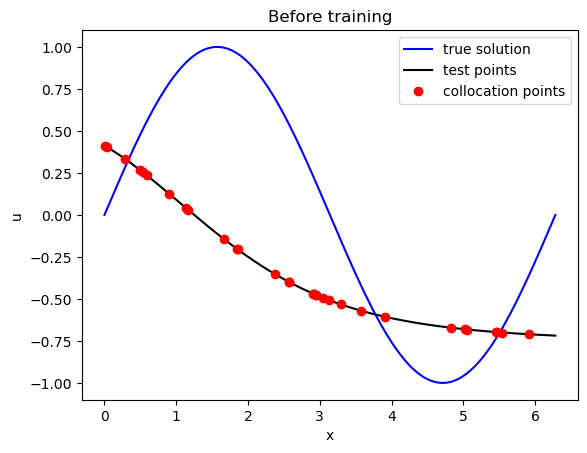

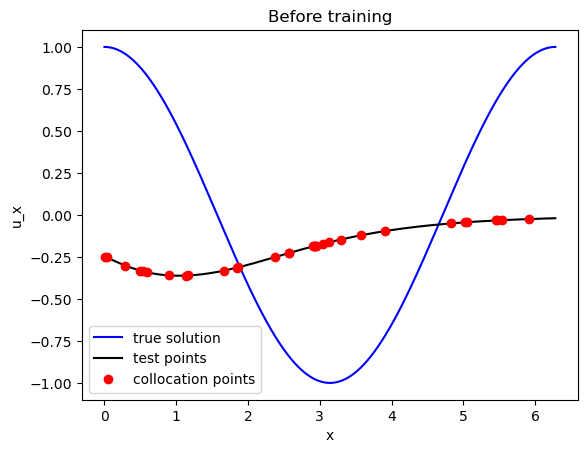

In [ ]:
def u_analytic(x):
    return np.sin(x)

def u_x_analytic(x):
    return np.cos(x)

# test points
xt = np.linspace(0, 2*np.pi, 1000).reshape(-1, 1)
u_true = u_analytic(xt)
u_x_true = u_x_analytic(xt)

xt = torch.tensor(xt, dtype=torch.float, requires_grad=True).to(device)
u_test = u_NN(xt)
u_x_test = torch.autograd.grad(u_test, xt, torch.ones_like(u_test), create_graph=True)[0]

plt.figure(1)
plt.plot(xt.detach().cpu().numpy(), u_true, 'b-', label='true solution')
plt.plot(xt.detach().cpu().numpy(), u_test.detach().cpu().numpy(), 'k-', label='test points')
plt.plot(x.detach().cpu().numpy(), u.detach().cpu().numpy(), 'ro', label='collocation points')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Before training')
plt.legend()

plt.figure(2)
plt.plot(xt.detach().cpu().numpy(), u_x_true, 'b-', label='true solution')
plt.plot(xt.detach().cpu().numpy(), u_x_test.detach().cpu().numpy(), 'k-', label='test points')
plt.plot(x.detach().cpu().numpy(), u_x.detach().cpu().numpy(), 'ro', label='collocation points')
plt.xlabel('x')
plt.ylabel('u_x')
plt.title('Before training')
plt.legend()

In [ ]:
from time import perf_counter
from tqdm import tqdm

In [ ]:
# Solution function u as Neural Networks
u_NN = MLP().to(device)

# points at boundary
x_bc = np.array([0, 2*np.pi]).reshape(-1, 1)
u_bc = np.array([0, 0]).reshape(-1, 1)
x_bc = torch.tensor(x_bc, dtype=torch.float, requires_grad=True).to(device)
u_bc = torch.tensor(u_bc, dtype=torch.float, requires_grad=True).to(device)

# collocation points
# x = np.linspace(0, 2*np.pi, 32).reshape(-1, 1)
# x = torch.tensor(x, dtype=torch.float, requires_grad=True).to(device)
x = torch.FloatTensor(32, 1).uniform_(0, 2*np.pi)
x.requires_grad = True
x = x.to(device)

# Optimizer
optimizer = torch.optim.Adam(u_NN.parameters(), lr=0.001)
# optimizer = torch.optim.LBFGS(u_NN.parameters(), lr=0.001)

# Loss function
mseloss = nn.MSELoss(reduction='mean')
lambda_bc = 1
lambda_de = 1

# Iterations
iterations = 1000

losses = {'loss':[], 'loss_bc':[], 'loss_de':[]}

t1 = perf_counter()
tqdm_iter = tqdm(range(iterations))
for i in tqdm_iter:
    
    # Boundary Conditions
    u_bc_pred = u_NN(x_bc)
    
    loss_bc = mseloss(u_bc, u_bc_pred)
    
    # Differential Equations
    u = u_NN(x)
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    
    loss_de = mseloss(u_x, f(x))
    
    loss = lambda_bc*loss_bc + lambda_de*loss_de
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    losses['loss'].append(loss.item())
    losses['loss_bc'].append(lambda_bc*loss_bc.item())
    losses['loss_de'].append(lambda_de*loss_de.item())
    if i==0 or i % 100 == 0 or i==iterations-1:
        # print(f'Iteration: {i} / Loss {loss}')
        tqdm_iter.set_postfix({'Loss': loss.item(), 'Loss BC': lambda_bc*loss_bc.item(), 'Loss DE': lambda_de*loss_de.item()})
t2 = perf_counter()

print('{} seconds'.format(t2-t1))

100%|██████████| 1000/1000 [00:01<00:00, 528.79it/s, Loss=0.0161, Loss BC=1.14e-5, Loss DE=0.0161]

1.893387068004813 seconds


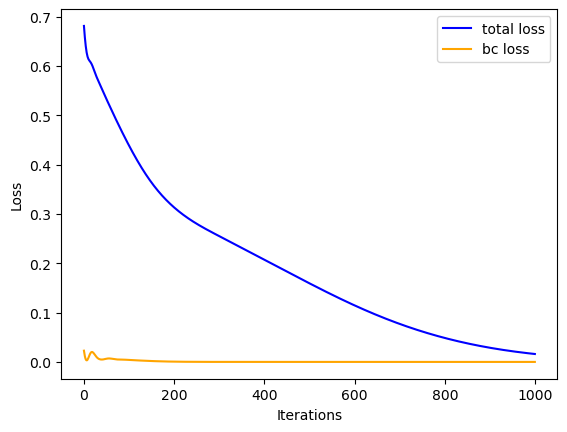

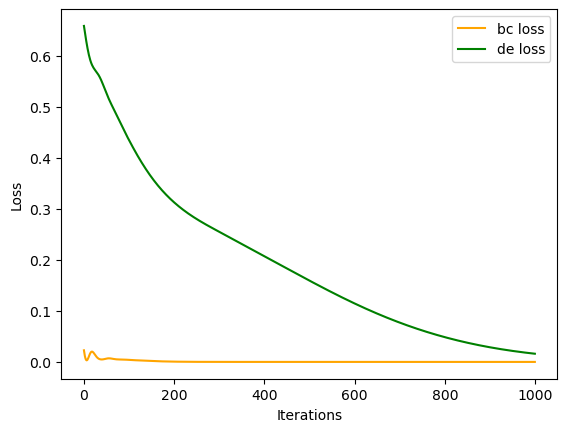

In [ ]:
plt.figure(1)
plt.plot(np.arange(iterations), losses['loss'], label='total loss', color='blue')
plt.plot(np.arange(iterations), losses['loss_bc'], label='bc loss', color='orange')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.figure(2)
plt.plot(np.arange(iterations), losses['loss_bc'], label='bc loss', color='orange')
plt.plot(np.arange(iterations), losses['loss_de'], label='de loss', color='green')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.show()

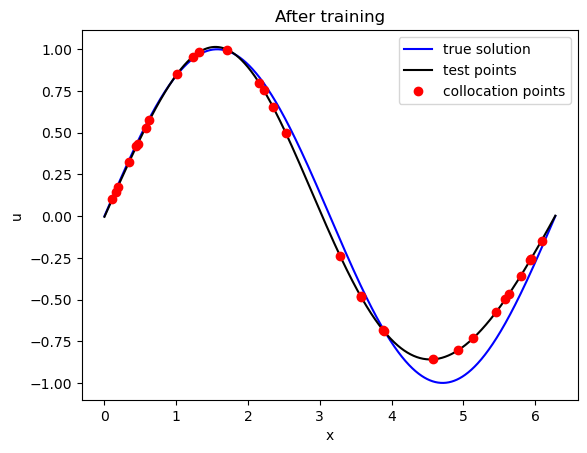

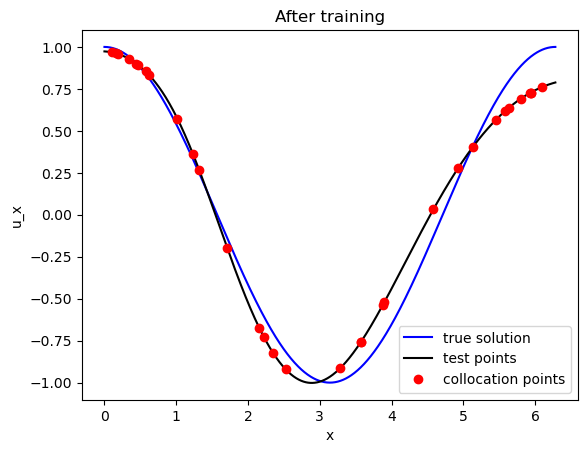

In [ ]:
# test points
xt = np.linspace(0, 2*np.pi, 1000).reshape(-1, 1)
u_true = u_analytic(xt)
u_x_true = u_x_analytic(xt)

xt = torch.tensor(xt, dtype=torch.float, requires_grad=True).to(device)
u_test = u_NN(xt)
u_x_test = torch.autograd.grad(u_test, xt, torch.ones_like(u_test), create_graph=True)[0]

plt.figure(1)
plt.plot(xt.detach().cpu().numpy(), u_true, 'b-', label='true solution')
plt.plot(xt.detach().cpu().numpy(), u_test.detach().cpu().numpy(), 'k-', label='test points')
plt.plot(x.detach().cpu().numpy(), u.detach().cpu().numpy(), 'ro', label='collocation points')
plt.xlabel('x')
plt.ylabel('u')
plt.title('After training')
plt.legend()

plt.figure(2)
plt.plot(xt.detach().cpu().numpy(), u_x_true, 'b-', label='true solution')
plt.plot(xt.detach().cpu().numpy(), u_x_test.detach().cpu().numpy(), 'k-', label='test points')
plt.plot(x.detach().cpu().numpy(), u_x.detach().cpu().numpy(), 'ro', label='collocation points')
plt.xlabel('x')
plt.ylabel('u_x')
plt.title('After training')
plt.legend()

plt.show()

## Mini-batch

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# Solution function u as Neural Networks
u_NN = MLP().to(device)

# points at boundary
x_bc = np.array([0, 2*np.pi]).reshape(-1, 1)
u_bc = np.array([0, 0]).reshape(-1, 1)
x_bc = torch.tensor(x_bc, dtype=torch.float, requires_grad=True).to(device)
u_bc = torch.tensor(u_bc, dtype=torch.float, requires_grad=True).to(device)
    
# collocation points
# x = np.linspace(0, 2*np.pi, 32).reshape(-1, 1)
# x = torch.tensor(x, dtype=torch.float, requires_grad=True).to(device)
x = torch.FloatTensor(32, 1).uniform_(0, 2*np.pi)
x.requires_grad = True
x = x.to(device)

dataset = TensorDataset(x)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
    
# Optimizer
optimizer = torch.optim.Adam(u_NN.parameters(), lr=0.001)

# Loss function
mseloss = nn.MSELoss(reduction='mean')
lambda_bc = 1
lambda_de = 1

# Iterations
iterations = 500

losses = {'loss':[], 'loss_bc':[], 'loss_de':[]}

t1 = perf_counter()
tqdm_iter = tqdm(range(iterations))
for i in tqdm_iter:
    for batch_idx, x_batchs in enumerate(dataloader):
        # Boundary Conditions
        u_bc_pred = u_NN(x_bc)

        loss_bc = mseloss(u_bc, u_bc_pred)

        # Differential Equations
        x_batch = x_batchs[0]
        u = u_NN(x_batch)
        u_x = torch.autograd.grad(u, x_batch, torch.ones_like(u), retain_graph=True, create_graph=True)[0]

        loss_de = mseloss(u_x, f(x_batch))

        loss = lambda_bc*loss_bc + lambda_de*loss_de
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
            

    losses['loss'].append(loss.item())
    losses['loss_bc'].append(lambda_bc*loss_bc.item())
    losses['loss_de'].append(lambda_de*loss_de.item())
    if i==0 or i % 100 == 0 or i==iterations-1:
        # print(f'Iteration: {i} / Loss {loss}')
        tqdm_iter.set_postfix({'Loss': loss.item(), 'Loss BC': lambda_bc*loss_bc.item(), 'Loss DE': lambda_de*loss_de.item()})
t2 = perf_counter()

print('{} seconds'.format(t2-t1))

100%|██████████| 500/500 [00:04<00:00, 114.53it/s, Loss=0.0378, Loss BC=0.00128, Loss DE=0.0365]

4.367065947008086 seconds


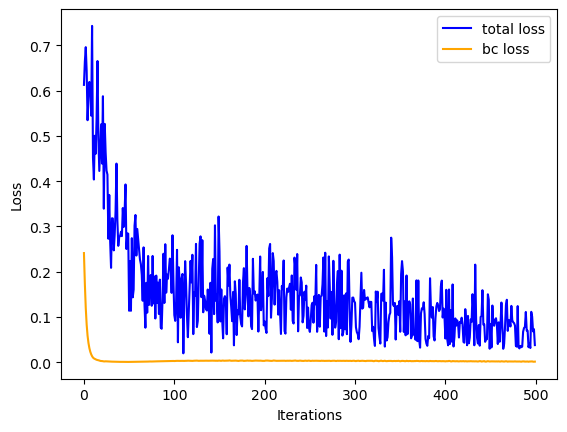

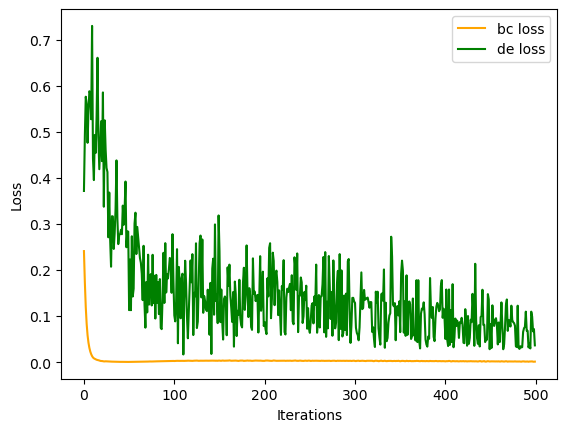

In [ ]:
plt.figure(1)
plt.plot(np.arange(iterations), losses['loss'], label='total loss', color='blue')
plt.plot(np.arange(iterations), losses['loss_bc'], label='bc loss', color='orange')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.figure(2)
plt.plot(np.arange(iterations), losses['loss_bc'], label='bc loss', color='orange')
plt.plot(np.arange(iterations), losses['loss_de'], label='de loss', color='green')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.show()

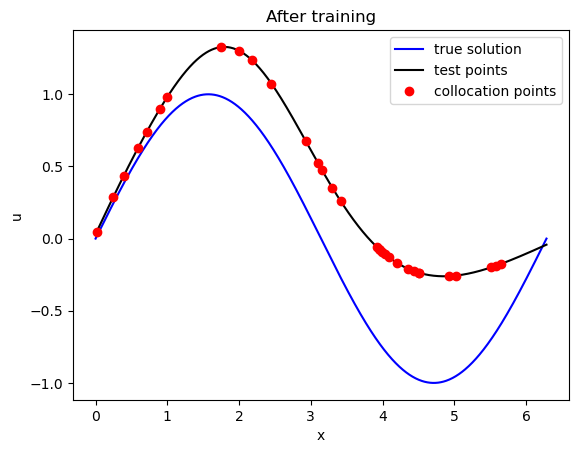

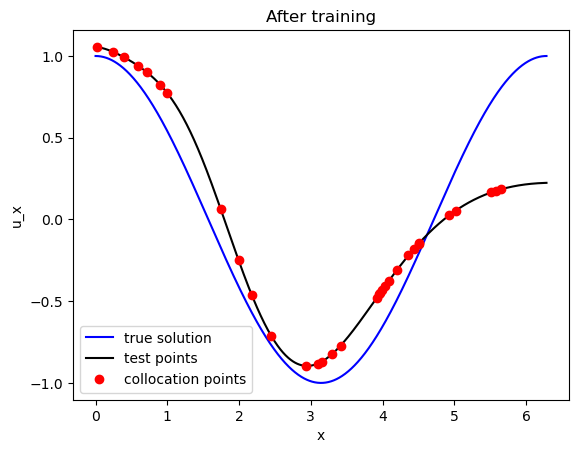

In [ ]:
u = u_NN(x)
u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]

# test points
xt = np.linspace(0, 2*np.pi, 1000).reshape(-1, 1)
u_true = u_analytic(xt)
u_x_true = u_x_analytic(xt)

xt = torch.tensor(xt, dtype=torch.float, requires_grad=True).to(device)
u_test = u_NN(xt)
u_x_test = torch.autograd.grad(u_test, xt, torch.ones_like(u_test), create_graph=True)[0]

plt.figure(1)
plt.plot(xt.detach().cpu().numpy(), u_true, 'b-', label='true solution')
plt.plot(xt.detach().cpu().numpy(), u_test.detach().cpu().numpy(), 'k-', label='test points')
plt.plot(x.detach().cpu().numpy(), u.detach().cpu().numpy(), 'ro', label='collocation points')
plt.xlabel('x')
plt.ylabel('u')
plt.title('After training')
plt.legend()

plt.figure(2)
plt.plot(xt.detach().cpu().numpy(), u_x_true, 'b-', label='true solution')
plt.plot(xt.detach().cpu().numpy(), u_x_test.detach().cpu().numpy(), 'k-', label='test points')
plt.plot(x.detach().cpu().numpy(), u_x.detach().cpu().numpy(), 'ro', label='collocation points')
plt.xlabel('x')
plt.ylabel('u_x')
plt.title('After training')
plt.legend()

plt.show()

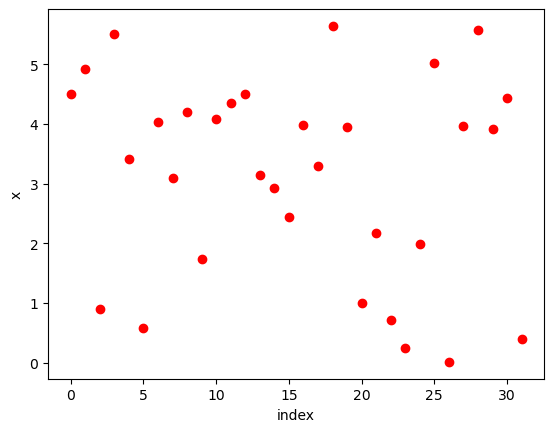

In [ ]:
plt.figure(1)
plt.plot(x.detach().cpu().numpy(), 'ro')
plt.ylabel('x')
plt.xlabel('index')
plt.show()